# <h1><center> PFAM Protein domain Classification </center></h1>

![protein.png](protein.png)

## 1. Problem Description

### 1.1 Description

Source: https://www.kaggle.com/googleai/pfam-seed-random-split </br>
Data : PFAM seed random split . </br>
Download random_split.zip . Which contains train dev and test data files.

- __Problem Statement :__ The task is , given the amino acid sequence of the protein domain, predict which family it belongs to.

### 1.2 Source/Useful links

1. https://www.biorxiv.org/content/10.1101/626507v3.full </br>
2. https://arxiv.org/pdf/1606.01781.pdf?
3. https://www.appliedaicourse.com/lecture/11/applied-machine-learning-online-course/3439/code-example-imdb-sentiment-classification/8/module-8-neural-networks-computer-vision-and-deep-learning

### 1.3 Real world objectives and constraints

* No low latency requirement.
* Interpretability is not important.
* Only sequence data is input data 

## 2. Deep Learning Problem Formulation

### 2.1 Data

* This directory contains data to train a model to predict the function of protein domains, based on the PFam dataset.

* Domains are functional sub-parts of proteins; much like images in ImageNet are pre segmented to contain exactly one object class, this data is presegmented to contain exactly and only one domain.

* The purpose of the dataset is to repose the PFam seed dataset as a multiclass classification machine learning task.

### 2.1.1 Data split and layout : 

The approach used to partition the data into training/dev/testing folds is a random split.

* Training data should be used to train your models.
* Dev (development) data should be used in a close validation loop (maybe for hyperparameter tuning or model validation).
* Test data should be reserved for much less frequent evaluations - this helps avoid overfitting on your test data, as it should only be used infrequently.

### 2.1.2 File Content

 Each fold (train, dev, test) has a number of files in it. Each of those files contains csv on each line, which has the following fields:

sequence: HWLQMRDSMNTYNNMVNRCFATCIRSFQEKKVNAEEMDCTKRCVTKFVGYSQRVALRFAE 
family_accession: PF02953.15
sequence_name: C5K6N5_PERM5/28-87
aligned_sequence: ....HWLQMRDSMNTYNNMVNRCFATCI...........RS.F....QEKKVNAEE.....MDCT....KRCVTKFVGYSQRVALRFAE 
family_id: zf-Tim10_DDP

__Description of fields:__  Sequence: These are usually the input features to your model. Amino acid sequence for this domain. There are 20 very common amino acids (frequency > 1,000,000), and 4 amino acids that are quite uncommon: X, U, B, O, Z.  
family_accession: These are usually the labels for your model. Accession number in form PFxxxxx.y (Pfam), where xxxxx is the family accession, and y is the version number. Some values of y are greater than ten, and so 'y' has two digits.  
family_id: One word name for family.  
sequence_name: Sequence name, in the form "$uniprotaccession_id/$start_index-$end_index".  
aligned_sequence: Contains a single sequence from the multiple sequence alignment (with the rest of the members of the family in seed, with gaps retained.

Generally, the family_accession field is the label, and the sequence (or aligned sequence) is the training feature.

This sequence corresponds to a domain, not a full protein.

### 2.2 Mapping the real world problem to Deep Learning problem

Since there are 18,000 output classes , so this is a multiclass classification problem

- __Performance Metric :__ We ll be using accuracy as our performance metric.

### 2.3 Deep learning constraints and objectives

__Objective :__ The objective is to predict the family of the given domain of a amino acid using the sequence data posing a multi class classification problem.

__Constraints :__

* No low latency requirement.
* Get a decent accuracy.
* Use only sequence data as input.

## Importing libraries

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import numpy
from keras.models import Sequential
from keras.layers import Dense , LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
numpy.random.seed(7)
from os import listdir
from tqdm import tqdm
#Supress scientific notation
pd.options.display.float_format = '{:20,.2f}'.format
import os
import seaborn as sns

Using TensorFlow backend.


## Loading the Data

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
os.listdir()

['.config', 'gdrive', 'sample_data']

In [0]:
os.chdir('gdrive/My Drive/')

In [4]:
# https://www.kaggle.com/drewbryant/starter-pfam-seed-random-split
# Since our data is present in three different files so loading the data from those files and storing it in our dataframes
def read_all_shards(partition='cv'):
    shards = []
    for fn in os.listdir(os.path.join(partition)):
        with open(os.path.join(partition, fn)) as f:
            shards.append(pd.read_csv(f, index_col=None))
    return pd.concat(shards)

test = read_all_shards('test')
cv = read_all_shards('dev')
train = read_all_shards('train')

partitions = {'test': test, 'cv': cv, 'train': train}
for name, df in partitions.items():
    print('Dataset partition "%s" has %d sequences' % (name, len(df)))

Dataset partition "test" has 126171 sequences
Dataset partition "cv" has 126171 sequences
Dataset partition "train" has 1086741 sequences


In [5]:
# checking for duplicates
print(train.duplicated().any())
print(cv.duplicated().any())
print(test.duplicated().any())

False
False
False


In [6]:
train.head()

,family_id,sequence_name,family_accession,aligned_sequence,sequence
0,GMC_oxred_C,A4WZS5_RHOS5/416-539,PF05199.13,PHPE.SRIRLST.RRDAHGMP.....IP.RIESRLGP............,PHPESRIRLSTRRDAHGMPIPRIESRLGPDAFARLRFMARTCRAIL...
1,DUF2887,K9QI92_9NOSO/3-203,PF11103.8,RDSIYYQIFKRFPALIFEL..VD.NRPPQAQNYRFESVEVKETAFR...,RDSIYYQIFKRFPALIFELVDNRPPQAQNYRFESVEVKETAFRIDG...
2,zf-IS66,Q92LC9_RHIME/32-75,PF13005.7,.TCCPDCGG.E..LRLVGED.AS....EILDMI.AAQMKVIEVARL...,TCCPDCGGELRLVGEDASEILDMIAAQMKVIEVARLKKSCRCCE
3,Asp_decarbox,X2GQZ4_9BACI/1-115,PF02261.16,MLRMMMNSKIHRATVTEADLNYVGSITIDEDILDAVGMLPNEKVHI...,MLRMMMNSKIHRATVTEADLNYVGSITIDEDILDAVGMLPNEKVHI...
4,Filamin,A7SQM3_NEMVE/342-439,PF00630.19,TACPKQ.CTA....RGLG.............LK.AAPVT.QPT..R...,TACPKQCTARGLGLKAAPVTQPTRFVVILNDCHGQPLGRSEGELEV...


In [7]:
# Here we'll be taking only 300k train datapoints and 10k cv and test datapoints because the original dataset has 1MM datapoints
# Working on 1MM datapoints can be computationally expensive
df_train = train[0:300000]
df_cv = cv[0:10000]
df_test = test[0:10000]
print("df_train: ", df_train.shape)
print("df_cv  : ", df_cv.shape)
print("df_test : ", df_test.shape)

df_train:  (300000, 5)
df_cv  :  (10000, 5)
df_test :  (10000, 5)


In [8]:
print("Number of unique classes in train set :", len(np.unique(df_train.family_accession)))
print("Number of unique classes in cv set :", len(np.unique(df_cv.family_accession)))
print("Number of unique classes in test set :", len(np.unique(df_test.family_accession)))
print("Number of unique classes in all the three datasets :",len(set(np.unique(df_test.family_accession)).union(set(np.unique(df_cv.family_accession)),set(np.unique(df_train.family_accession)))))

Number of unique classes in train set : 16341
Number of unique classes in cv set : 4921
Number of unique classes in test set : 4934
Number of unique classes in all the three datasets : 16353


In [9]:
common_class = set(np.unique(df_test.family_accession)).intersection(set(np.unique(df_cv.family_accession)),set(np.unique(df_train.family_accession)))
print("Number of common classes in train cv and test data :", len(common_class))

Number of common classes in train cv and test data : 2900


In [10]:
# Selecting the datapoints with the common family accession in all the three datasets.
df_train = df_train.loc[df_train['family_accession'].isin(common_class)].reset_index()
df_cv = df_cv.loc[df_cv['family_accession'].isin(common_class)].reset_index()
df_test = df_test.loc[df_test['family_accession'].isin(common_class)].reset_index()
print("Shape of our train data : ",df_train.shape)
print("Shape of our cv data : ",df_cv.shape)
print("Shape of our test data : ",df_test.shape)

Shape of our train data :  (174649, 6)
Shape of our cv data :  (7359, 6)
Shape of our test data :  (7370, 6)


**So we are left with approx 174k train datapoints 7359 cv datapoints and 7370 test datapoints.**

In [11]:
df_train.head()

,index,family_id,sequence_name,family_accession,aligned_sequence,sequence
0,0,GMC_oxred_C,A4WZS5_RHOS5/416-539,PF05199.13,PHPE.SRIRLST.RRDAHGMP.....IP.RIESRLGP............,PHPESRIRLSTRRDAHGMPIPRIESRLGPDAFARLRFMARTCRAIL...
1,3,Asp_decarbox,X2GQZ4_9BACI/1-115,PF02261.16,MLRMMMNSKIHRATVTEADLNYVGSITIDEDILDAVGMLPNEKVHI...,MLRMMMNSKIHRATVTEADLNYVGSITIDEDILDAVGMLPNEKVHI...
2,4,Filamin,A7SQM3_NEMVE/342-439,PF00630.19,TACPKQ.CTA....RGLG.............LK.AAPVT.QPT..R...,TACPKQCTARGLGLKAAPVTQPTRFVVILNDCHGQPLGRSEGELEV...
3,6,GGACT,A0A086WQ80_9VIBR/5-113,PF06094.12,LFVY...GTLRQG..ESNH.N.F.L.AD.....S...Q...........,LFVYGTLRQGESNHNFLADSQCLGHFETPPHYALYDLGTYPAVIEG...
4,8,His_kinase,Q47E94_DECAR/372-450,PF06580.13,SE.I..KLLHAQVNPHFLFNALNTL......S....AV...I.......,SEIKLLHAQVNPHFLFNALNTLSAVIRRDPEKACHLVLNLSTFFRK...


## Exploaratory Data Analysis

Now let us perform some Exploratory analysis on our data.

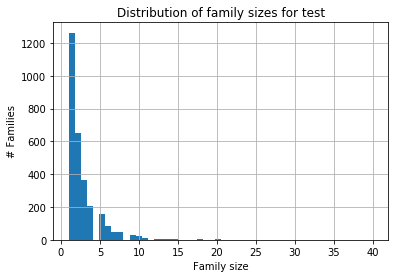

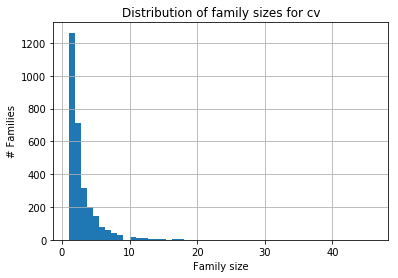

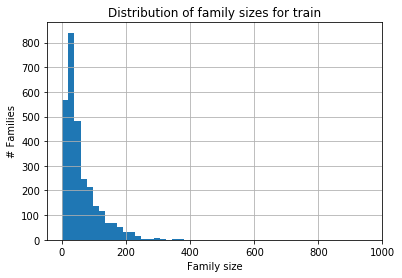

In [12]:
partitions = {'test': df_test, 'cv': df_cv, 'train': df_train}
for name, partition in partitions.items():
    partition.groupby('family_accession').size().hist(bins=50)
    plt.title('Distribution of family sizes for %s' % name)
    plt.ylabel('# Families')
    plt.xlabel('Family size')
    plt.show()

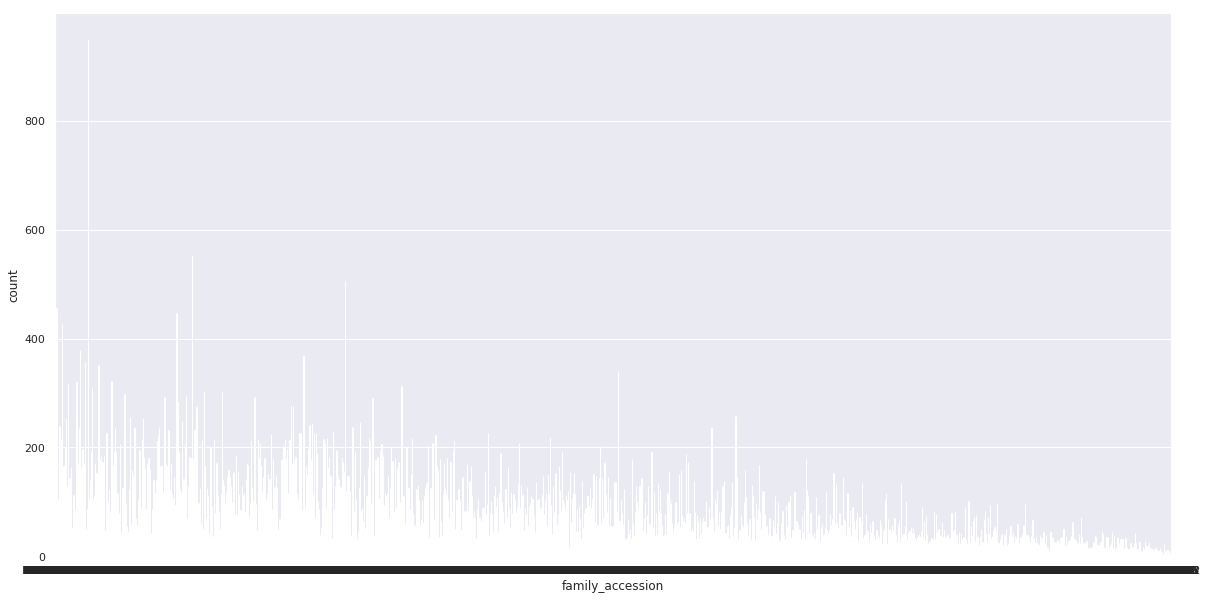

In [13]:
plt.figure(figsize=(20,10))
sns.set(style="darkgrid")
ax = sns.countplot(x="family_accession", data=df_train)
plt.show()

In [0]:
#### Train Sequence length percentiles
train_des = pd.DataFrame(df_train.sequence.map(len)).describe(include = 'all', percentiles = [.1, .2, .3, .4, .5, .6, .7, .8, .9])

#### Dev Sequence length percentiles
cv_des = pd.DataFrame(df_cv.sequence.map(len)).describe(include = 'all', percentiles = [.1, .2, .3, .4, .5, .6, .7, .8, .9])

#### Test Sequence length percentiles
test_des = pd.DataFrame(df_test.sequence.map(len)).describe(include = 'all', percentiles = [.1, .2, .3, .4, .5, .6, .7, .8, .9])

Text(0, 0.5, 'length of sequence')

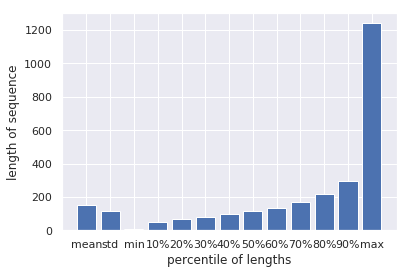

In [0]:
y_pos = np.arange(13)
ticks = ['mean','std','min','10%','20%','30%','40%','50%','60%','70%','80%','90%','max']
plt.bar(y_pos ,(train_des[1:].sequence), label='train')
s = plt.xticks(y_pos,ticks)
plt.xlabel('percentile of lengths')
plt.ylabel('length of sequence')

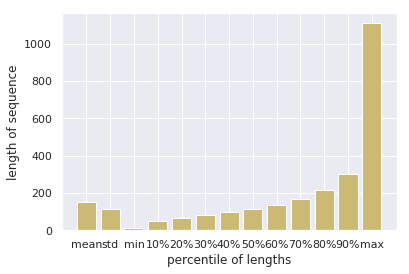

In [0]:
plt.bar(y_pos ,cv_des[1:].sequence,color='y')
plt.xlabel('percentile of lengths')
plt.ylabel('length of sequence')
s = plt.xticks(y_pos,ticks)

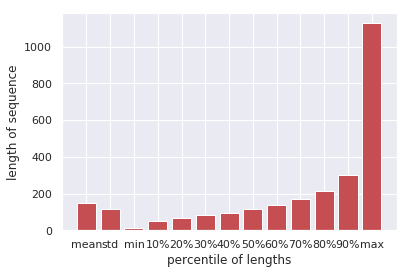

In [0]:
plt.bar(y_pos ,test_des[1:].sequence,color='r')
plt.xlabel('percentile of lengths')
plt.ylabel('length of sequence')
s = plt.xticks(y_pos,ticks)

Following are the plots of the most frequent family_ids and their counts


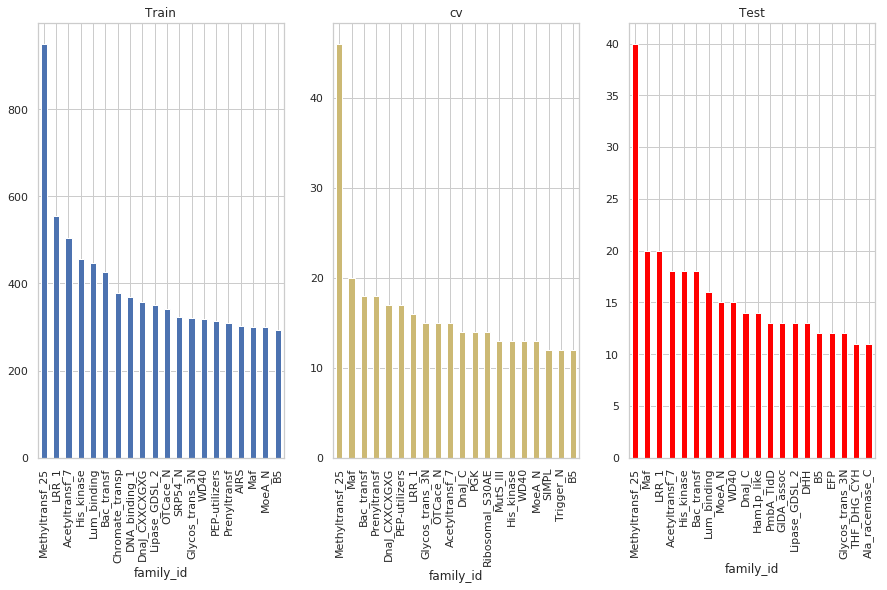

In [39]:
print('Following are the plots of the most frequent family_ids and their counts')
plt.figure(figsize=(15,8))
plt.subplot(1,3,1)
plt.title('Train')
df_train.groupby('family_id').size().sort_values(ascending=False).head(20).plot('bar')
plt.subplot(1,3,2)
plt.title('cv')
df_cv.groupby('family_id').size().sort_values(ascending=False).head(20).plot('bar',color='y')
plt.subplot(1,3,3)
plt.title('Test')
df_test.groupby('family_id').size().sort_values(ascending=False).head(20).plot('bar',color='red')
plt.show()

## Utility Functions

In [0]:
import time
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
def plt_dynamic( x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()
    plt.show()

In [0]:
def space_in_sequence(word):
    '''
    Space in sequence. Example: 'ABCDEFG' to ' A B C D E F G'
    '''
    s_= ''
    for i in range(0, len(word), 1):
        s_ = s_ + ' ' + word[i]
    return s_

def top_freq_features(df, n):
    return df[:n]
space_in_sequence(df_train.sequence[2])

In [0]:
def compile_execute_model():
    """Compile, execute and evaluate the model. Get "Categorical Crossentropy Loss" vs "epocs" plot"""
    print("Model Summary:")
    model.summary()
    print("Model Compilation:")
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    print("Model Execution:")
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_cv, y_cv))
    score = model.evaluate(X_test, y_test, verbose=0) 
    print('cv score:', score[0]) 
    print('cv accuracy:', score[1])
    
    model_pretty_table.add_row([model_name, round(score[0]*100,2), round(score[1]*100,2)])
    
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

    # list of epoch numbers
    x = list(range(1,nb_epoch+1))

    vy = history.history['val_loss']
    ty = history.history['loss']
    plt_dynamic(fig, x, vy, ty, ax)

In [0]:
def get_index(word):
    '''This function is to get the index of the char from the feature frequency dataframe'''
    word = word.lower()
    temp = df['feature'] == word
    temp_sum = np.array(temp).sum()
    if(temp_sum ==1):
        return df.index[df['feature'] == word].tolist()[0]
    else:
        return top_words

In [0]:
def right_padding_with_index(x_train, max_seq_length):
    '''this function is to get the right padded index_sequences'''
    from tqdm import tqdm
    #X_train = numpy.zeros((x_train.shape[0], max_seq_length), dtype = 'int')
    lis =[]
    i = 0
    for j in tqdm(np.arange(0,len(x_train))):
        x = x_train[j]
        x_iter = map(get_index, x.split())
        l1 = list(x_iter)
        lis.append(l1)
    arr = sequence.pad_sequences(lis, maxlen=100, padding='post')
    return arr

In [0]:
from keras.utils import np_utils
def get_categorical(y_train, number_of_unique_classes):
    '''This function is to convert into one hot encoded vectors'''
    Y_train = []
    for label in y_train:
        label_ = np_utils.to_categorical(label , number_of_unique_classes) 
        Y_train.append(label_)
    Y_train = np.array(Y_train)
    return Y_train

In [0]:
#Performing the Spacing between the characters of the sequence
x_train = (df_train.sequence).apply(space_in_sequence)
x_cv    = (df_cv.sequence).apply(space_in_sequence)
x_test  = (df_test.sequence).apply(space_in_sequence)

In [0]:
values   = np.arange(0,len(df_train.family_accession.unique()),1)
keys = df_train.family_accession.unique()
dict_class = dict(zip(keys, values))

y_train = df_train.family_accession.apply(lambda x: dict_class[x])
y_cv    = df_cv.family_accession.apply(lambda x: dict_class[x])
y_test  = df_test.family_accession.apply(lambda x: dict_class[x])

In [0]:
bow_scalar = CountVectorizer(token_pattern = r"(?u)\b\w+\b")
bow_scalar.fit(x_train.values)

final_counts = bow_scalar.transform(x_train.values).toarray()
final_counts = final_counts.sum(axis=0)
final_counts.shape

(23,)

In [0]:
final_counts     # Overall count of each character in complete data corpus

array([2302173,       3,  347613, 1428929, 1640466, 1088157, 1925519,
        565572, 1631716, 1367811, 2616177,  583577,  984063, 1119584,
        910792, 1444935, 1549521, 1393216,       8, 1904620,  337636,
           249,  840470])

In [0]:
df = pd.DataFrame({ 'feature': bow_scalar.get_feature_names(),'frequency': list(final_counts) })
df.sort_values('frequency', ascending = False, inplace = True)
df.reset_index(drop=True, inplace = True)
df.head(25)

,feature,frequency
0,l,2616177
1,a,2302173
2,g,1925519
3,v,1904620
4,e,1640466
5,i,1631716
6,s,1549521
7,r,1444935
8,d,1428929
9,t,1393216


In [0]:
top_words = 20       # We ll be taking only top 20 words
max_seq_length = 100  # Max length of a sequence is to be 100 only
from tqdm import tqdm
df = top_freq_features(df, top_words)

In [0]:
unique_indexes = top_words + 1
print("unique_indexes: ", unique_indexes)

unique_indexes:  21


In [0]:
from tqdm import tqdm
if not os.path.isfile('X_train.csv'):
    print("calculating X_train ...")
    %time X_train = right_padding_with_index(x_train[:], max_seq_length)     #performing right padding on our data
    %time pd.DataFrame(X_train).to_csv("X_train.csv", index=False, mode = 'w', header = True)


if not os.path.isfile('X_cv.csv'):
    print("calculating X_cv ...")
    %time X_cv = right_padding_with_index(x_cv[:], max_seq_length)
    %time pd.DataFrame(X_cv).to_csv("X_cv.csv", index=False, mode = 'w', header = True)


if not os.path.isfile('X_test.csv'):
    print("calculating X_test ...")
    %time X_test  = right_padding_with_index(x_test[:], max_seq_length)
    %time pd.DataFrame(X_test).to_csv("X_test.csv", index=False, mode = 'w', header = True)


  0%|          | 2/174649 [00:00<4:09:03, 11.69it/s]

calculating X_train ...


100%|██████████| 174649/174649 [4:23:26<00:00, 11.05it/s]


CPU times: user 4h 22min 20s, sys: 2min 5s, total: 4h 24min 26s
Wall time: 4h 23min 28s


  0%|          | 3/7359 [00:00<05:08, 23.82it/s]

CPU times: user 14.2 s, sys: 92.9 ms, total: 14.3 s
Wall time: 14.5 s
calculating X_cv ...


100%|██████████| 7359/7359 [11:57<00:00, 10.26it/s]


CPU times: user 11min 34s, sys: 24.2 s, total: 11min 58s
Wall time: 11min 57s


  0%|          | 1/7370 [00:00<18:33,  6.62it/s]

CPU times: user 585 ms, sys: 5.97 ms, total: 591 ms
Wall time: 602 ms
calculating X_test ...


100%|██████████| 7370/7370 [11:33<00:00, 10.63it/s]


CPU times: user 11min 18s, sys: 17.1 s, total: 11min 35s
Wall time: 11min 33s
CPU times: user 619 ms, sys: 1.98 ms, total: 621 ms
Wall time: 634 ms


In [0]:
import numpy as np
def one_hot(final_sequence):
    nb_classes = 21                          # This is to convert our indexed data into one hot coded data
    targets = np.array(final_sequence)
    one_hot_train = np.eye(nb_classes)[targets]
    
    return one_hot_train

In [0]:
X_train.shape

(174649, 100)

In [5]:
# Now we load the indexed sequences to convert them into one hot encoded vectors
X_train        = pd.read_csv("X_train.csv").values
%time ohe_train  = one_hot(X_train[:])  
X_cv           = pd.read_csv("X_cv.csv").values 
%time ohe_cv     = one_hot(X_cv[:]) 
X_test        = pd.read_csv("X_test.csv").values 
%time ohe_test   = one_hot(X_test[:]) 

print("X_train: ", ohe_train.shape); print(ohe_train[0:5])
print("X_cv: ", ohe_cv.shape);       print(ohe_cv[0:5])
print("X_test: ", ohe_test.shape);   print(ohe_test[0:5])

CPU times: user 418 ms, sys: 1.28 s, total: 1.7 s
Wall time: 1.71 s
CPU times: user 27.2 ms, sys: 766 µs, total: 28 ms
Wall time: 29.4 ms
CPU times: user 18.5 ms, sys: 51.9 ms, total: 70.4 ms
Wall time: 70.5 ms
X_train:  (174649, 100, 21)
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 1. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 1. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 1. 0.]
  [0. 0. 0. ... 1. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0.

In [0]:
number_of_unique_classes = len(common_class)

In [0]:
Y_train = get_categorical(y_train , number_of_unique_classes)      #converting our labelled data into one hot coded class data
Y_cv = get_categorical(y_cv , number_of_unique_classes)
Y_test = get_categorical(y_test , number_of_unique_classes)

In [0]:
np.save('Y_train',Y_train)
np.save('Y_cv',Y_cv)
np.save('Y_test',Y_test)

In [0]:
Y_train = np.load('Y_train.npy')
Y_cv = np.load('Y_cv.npy')
Y_test = np.load('Y_test.npy')

In [0]:
Y_train.shape

(174649, 2900)

## Building Models

__Using LSTM :__ We used LSTM to secure the sequence information by following the above process , we had our data upto the indexed form , we coverted this data into embedded data and perform LSTM operations but couldn't get an accuracy greater than 0.04 . 

__Using CNNs :__ We used some simple and complex architectures of CNN but the accuracy didnot exceed 0.05 . As we are dealing with the text data so we are using Conv1D. Because of this we land up building a model which is taken from https://arxiv.org/abs/1606.01781

In [0]:
from keras.layers import BatchNormalization,Dropout,Conv1D,Activation,Add,Flatten,Dense
from keras.layers import MaxPooling1D
from keras.layers.merge import concatenate
from keras.initializers import glorot_uniform
from keras.layers import ZeroPadding1D
from keras.models import Input,Model

import warnings 
warnings.filterwarnings('ignore')

In [9]:
input_s = Input(shape=(100,21))
print(input_s.shape)



(?, 100, 21)


In [0]:
X  = Conv1D(32, 1 , strides=1,padding='valid', name='conv1d_1', kernel_initializer=glorot_uniform(seed=0))(input_s)

X  = MaxPooling1D(pool_size=2)(X)
X1 = BatchNormalization(axis=2, name='batch_normalization_1')(X)

X2 = Activation('relu',name='activation_1')(X1)

X3 = BatchNormalization(axis=2, name='batch_normalization_2')(X2)

X4 = Activation('relu',name='activation_2')(X3)

X5 = Conv1D(128, 1 , strides=1,padding='valid', name='conv1d_3', kernel_initializer=glorot_uniform(seed=0))(X4)

#X5 = MaxPooling1D(pool_size=2,name='pooling2')(X5)
# https://github.com/Mrjaggu/pfam_protein_sequence_classification

X6 = BatchNormalization(axis=2, name='batch_normalization_3')(X5)

X7 = Activation('relu',name='activation_3')(X6)

X8 = Conv1D(128 , 1 , strides=1 ,padding='valid', name='conv1d_4' , kernel_initializer=glorot_uniform(seed=0))(X7)
X8 = Dropout(0.5,name='d3')(X8)
X8 = MaxPooling1D(pool_size=2)(X8)

X9 = Conv1D(128,  1 , strides=1 ,padding ='valid',name='conv1d_2',  kernel_initializer=glorot_uniform(seed=0))(X2)
X9 = Dropout(0.5,name='d7')(X9)
X9 = MaxPooling1D(pool_size=2)(X9)

X10 = Add()([X8,X9])

X11 = Activation('relu',name='activation_4')(X10)
X11 = Dropout(0.2)(X11)

X12 = BatchNormalization(axis=2,name='batch_normalization_4')(X11)

X13 = Activation('relu',name='activation_5')(X12)

X14 = Dropout(0.5,name='dropout_1')(X13)

X15 = Flatten(name='flatten_1')(X14)

X16 = Dense(2900 ,name='fc' + str(2900), kernel_initializer = glorot_uniform(seed=0))(X15)

X17 = Activation('softmax',name='activation_6')(X16)

In [0]:
# Create model
model = Model(inputs = input_s, outputs = X17)

In [14]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 21)      0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 100, 32)      704         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_7 (MaxPooling1D)  (None, 50, 32)       0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 50, 32)       128         max_pooling1d_7[0][0]            
____________________________________________________________________________________________

In [0]:
ohe_train.shape

(174649, 100, 21)

In [15]:
history=model.fit(ohe_train, Y_train, epochs=30, batch_size=256 , validation_data=(ohe_cv,Y_cv), verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 174649 samples, validate on 7359 samples
Epoch 1/30
174649/174649 [==============================] - 396s 2ms/step - loss: 3.3377 - acc: 0.5061 - val_loss: 1.4807 - val_acc: 0.8199
Epoch 2/30
174649/174649 [==============================] - 395s 2ms/step - loss: 0.9140 - acc: 0.8232 - val_loss: 0.7934 - val_acc: 0.8886
Epoch 3/30
174649/174649 [==============================] - 398s 2ms/step - loss: 0.5440 - acc: 0.8861 - val_loss: 0.5734 - val_acc: 0.9083
Epoch 4/30
174649/174649 [==============================] - 396s 2ms/step - loss: 0.3692 - acc: 0.9168 - val_loss: 0.4908 - val_acc: 0.9152
Epoch 5/30
174649/174649 [==============================] - 400s 2ms/step - loss: 0.2692 - acc: 0.9357 - val_loss: 0.4554 - val_acc: 0.9213
Epoch 6/30
174649/174649 [==============================] - 401s 2ms/step - loss: 0.2181 - acc: 0.9460 - val_loss: 0.4464 - val_acc: 0.9228
Epoch 7/30
17464

Test score: 0.40879518702181417
Test accuracy: 0.9363636363312865


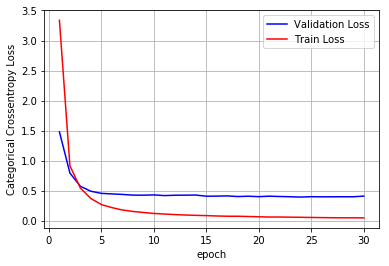

In [18]:
score = model.evaluate(ohe_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,30+1))

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

In [0]:
model.save('model.h5')

In [0]:
np.save('history',history)

In [0]:
history = np.load('history.npy',allow_pickle=True)

In [0]:
from keras.models import load_model

In [48]:
model = load_model('model.h5')




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [21]:
score = model.evaluate(ohe_test, Y_test , verbose=1)

7370/7370 [==============================] - 7s 893us/step


In [22]:
print("Test loss:",score[0])
print("Test accuracy:",score[1])

Test loss: 0.40879518702181417
Test accuracy: 0.9363636363312865


****Following are the steps taken to solve this case study :****

- __Objective :__ The task is to predict the protein family from the given sequence of amino acid domain.
- __Data :__ The data that we are provided with is in three different files train, dev and test. Each line has a dataframe .The description of the data can be found in the Data description part which is well explained in the very start of this notebook .We load the data from these three files and store in our dataframes train ,cv and test.  
Since the data that we have is way too large with more than a million training data points and 18000 class labels , this can prove out to be computationally infeasible to perform on this much data so we chose just 300k training data points and 10k test and cv data points.  
We have sequence data as our input and the family_accession is our class label . The sequence consists of A-Z characters of which 20 are the most frequent .
- __Data Preprocessing :__ We find the class labels which are present in all the datasets train, cv and test and choose only those datapoints from train cv and test which have those class labels . We check if there are any duplicate datapoints in our data.  
- __Exploratory data Analysis :__ We perform some EDA on our data to get an idea how our data is distributed , we find out that some class labels are very frequent and some are so rare. Our data is imbalanced .  
- __Data Preparation/ Featurization :__ Now we find out the characters which are the most frequent and which are the least frequent and arrange them in descending order of their count and store it as a dataframe along with their index. These indices are what we are going to deal with now. We take each sequence , we fill spaces between each character and now we replace each character by the index of that character in the frequency-feature dataframe . We have choosen our sequence to be of maximum length 100 and we ll be taking top 21 features or characters as last 3 characters are very rare.  We perform right padding of our vectors.  
Since we have taken top 21 characters now we one hot encode our indices so finally we ll be left with the shape (? , 100 ,21) .  
- __Deep Learning Models :__ First we built LSTM models by just using the indices as our vectors converting them to embedded vectors but the accuracy was not so good . Then we built some simple and little complex convolution networks which too didnot perform good . So then we built very deep convolution networks for text classification . We compiled the model and fit on our train data and validated on our CV data ,after 30 epochs the results were impressive and better than all .

In [0]:
from prettytable import PrettyTable

In [36]:
x = PrettyTable(['Model','train loss','epochs','test loss','train accuracy','test accuracy'])
x.add_row(['Deep CNN',0.0468,30,0.4087 ,0.9864, 0.9363])
print(x)

+----------+------------+--------+-----------+----------------+---------------+
|  Model   | train loss | epochs | test loss | train accuracy | test accuracy |
+----------+------------+--------+-----------+----------------+---------------+
| Deep CNN |   0.0468   |   30   |   0.4087  |     0.9864     |     0.9363    |
+----------+------------+--------+-----------+----------------+---------------+
